**1.ทดสอบโมเดลด้วยชุดข้อมูล train ทั้งหมด + Augmentation**

**ทำการเชื่อมต่อกับ Google Drive**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


**ทำการ Unzip Dataset ที่ต้องใช้**

In [2]:
!unzip "/content/drive/MyDrive/dataset_durian/train-20251011T120712Z-1-001.zip" -d "/content/dataset/"
!unzip "/content/drive/MyDrive/dataset_durian/test_1-20251011T120708Z-1-001.zip" -d "/content/dataset/"
!unzip "/content/drive/MyDrive/dataset_durian/test_2-20251011T120736Z-1-001.zip" -d "/content/dataset/"

Archive:  /content/drive/MyDrive/dataset_durian/train-20251011T120712Z-1-001.zip
  inflating: /content/dataset/train/sunburn/sunburn_901.jpg  
  inflating: /content/dataset/train/leafhopper/leafhopper_970.jpg  
  inflating: /content/dataset/train/leafhopper/leafhopper_985.jpg  
  inflating: /content/dataset/train/sunburn/sunburn_708.jpg  
  inflating: /content/dataset/train/leafhopper/leafhopper_987.jpg  
  inflating: /content/dataset/train/sunburn/sunburn_722.jpg  
  inflating: /content/dataset/train/sunburn/sunburn_872.jpg  
  inflating: /content/dataset/train/sunburn/sunburn_795.jpg  
  inflating: /content/dataset/train/sunburn/sunburn_348.jpg  
  inflating: /content/dataset/train/leafhopper/leafhopper_982.jpg  
  inflating: /content/dataset/train/sunburn/sunburn_144.jpg  
  inflating: /content/dataset/train/leafhopper/leafhopper_649.jpg  
  inflating: /content/dataset/train/leafhopper/leafhopper_859.jpg  
  inflating: /content/dataset/train/leafhopper/leafhopper_973.jpg  
  inflati

**โหลดชุดข้อมูลและเตรียมข้อมูลสำหรับการฝึกโมเดล**

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# กำหนดค่าพารามิเตอร์ต่างๆ
IMG_SIZE = 224  # ขนาดรูปภาพที่ EfficientNetB0 ต้องการ
BATCH_SIZE = 32 # จำนวนข้อมูลที่ส่งให้โมเดลในแต่ละรอบ
EPOCHS = 50      # จำนวนรอบในการเทรนโมเดล

# กำหนดค่าพารามิเตอร์สำหรับสัดส่วนการแบ่งข้อมูลใหม่
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2

# ตรวจสอบให้แน่ใจว่าสัดส่วนรวมกันได้ 1.0
assert (TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT) == 1.0

DATASET_DIR = "/content/dataset/train"
DATASET_TEST_1 = "/content/dataset/test_1"
DATASET_TEST_2 = "/content/dataset/test_2"

# สร้างเลเยอร์สำหรับเพิ่มข้อมูลสังเคราะห์
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# เราจะโหลดข้อมูลจาก train, test_1, และ test_2 แยกกันก่อน
train_full_ds_raw = tf.keras.utils.image_dataset_from_directory(
    directory = DATASET_DIR, # ใช้ DATASET_DIR ที่เคยกำหนดไว้คือ "/content/dataset/train"
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = None, # ไม่ต้องใส่ batch_size ตอนโหลดครั้งแรก
    shuffle=False, # ไม่ต้อง shuffle ตอนโหลดครั้งแรก
    seed = 42
)

test_1_full_ds_raw = tf.keras.utils.image_dataset_from_directory(
    directory = DATASET_TEST_1, # ใช้ DATASET_TEST_1 ที่เคยกำหนดไว้คือ "/content/dataset/test_1"
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = None,
    shuffle=False,
    seed = 42
)

test_2_full_ds_raw = tf.keras.utils.image_dataset_from_directory(
    directory = DATASET_TEST_2, # ใช้ DATASET_TEST_2 ที่เคยกำหนดไว้คือ "/content/dataset/test_2"
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = None,
    shuffle=False,
    seed = 42
)

# รวม Datasets ทั้งหมดเข้าด้วยกัน
all_ds_raw = train_full_ds_raw.concatenate(test_1_full_ds_raw).concatenate(test_2_full_ds_raw)

# นับจำนวนข้อมูลทั้งหมดที่แท้จริง
total_files = tf.data.experimental.cardinality(all_ds_raw).numpy()
print(f"จำนวนไฟล์รูปภาพทั้งหมด: {total_files}")

# คำนวณจำนวนข้อมูลสำหรับแต่ละชุดใหม่
train_size = int(TRAIN_SPLIT * total_files)
val_size = int(VAL_SPLIT * total_files)
test_size = total_files - train_size - val_size # ใช้ที่เหลือเป็น test เพื่อความถูกต้อง

print(f"จำนวนข้อมูล Train ใหม่: {train_size}")
print(f"จำนวนข้อมูล Validation ใหม่: {val_size}")
print(f"จำนวนข้อมูล Test ใหม่: {test_size}")

# ทำการสุ่มข้อมูลก่อนแบ่ง
all_ds_raw = all_ds_raw.shuffle(buffer_size=total_files, seed=42)

# แบ่งข้อมูลโดยใช้ take และ skip
train_ds = all_ds_raw.take(train_size)
remaining_ds = all_ds_raw.skip(train_size)

val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size) # ที่เหลือเป็น test

# ตรวจสอบจำนวนข้อมูลในแต่ละชุดหลังจากแบ่ง
print(f"\nจำนวนข้อมูลใน train_ds: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"จำนวนข้อมูลใน val_ds: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"จำนวนข้อมูลใน test_ds: {tf.data.experimental.cardinality(test_ds).numpy()}")

# แก้ไข: ดึง class_names มาจาก Dataset ที่โหลดจาก directory โดยตรง
# เนื่องจาก Dataset ทั้งหมดมาจาก directory เดียวกัน class_names ควรจะเหมือนกัน
NUM_CLASSES = len(train_full_ds_raw.class_names)


# ฟังก์ชันสำหรับปรับขนาดและประมวลผลรูปภาพให้พร้อมสำหรับโมเดล
def preprocess_image(image, label):
    image = tf.keras.applications.efficientnet.preprocess_input(image) # ฟังก์ชันเฉพาะของ EfficientNet
    return image, label

# สร้าง Data Pipeline
# สำหรับ Train: เพิ่มข้อมูล (augment) -> ปรับขนาด (preprocess) -> เตรียมข้อมูลล่วงหน้า (prefetch) -> Batch
train_ds_aug = (train_ds
            .cache()
            .shuffle(buffer_size=1000)
            .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE) # เพิ่ม Batching หลัง Augmentation
            .prefetch(tf.data.AUTOTUNE))

# สำหรับ Validation และ Test: ปรับขนาด (preprocess) -> เตรียมข้อมูลล่วงหน้า (prefetch) -> Batch
val_ds  = (val_ds
           .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE) # เพิ่ม Batching
           .cache().prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds
           .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE) # เพิ่ม Batching
           .cache().prefetch(tf.data.AUTOTUNE))

# ตรวจสอบจำนวน Batch ในแต่ละชุดข้อมูลหลังจาก Batching
print(f"\nจำนวน Batch ใน train_ds_aug: {tf.data.experimental.cardinality(train_ds_aug).numpy()}")
print(f"จำนวน Batch ใน val_ds: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"จำนวน Batch ใน test_ds: {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 4000 files belonging to 4 classes.
Found 15 files belonging to 4 classes.
Found 11 files belonging to 4 classes.
จำนวนไฟล์รูปภาพทั้งหมด: 4026
จำนวนข้อมูล Train ใหม่: 2818
จำนวนข้อมูล Validation ใหม่: 402
จำนวนข้อมูล Test ใหม่: 806

จำนวนข้อมูลใน train_ds: 2818
จำนวนข้อมูลใน val_ds: 402
จำนวนข้อมูลใน test_ds: 806

จำนวน Batch ใน train_ds_aug: 89
จำนวน Batch ใน val_ds: 13
จำนวน Batch ใน test_ds: 26


**โหลดโมเดลและเพิ่มส่วนของ Layer Output**

In [ ]:
# โหลด EfficientNetB0 ที่เทรนด้วย 'imagenet'
# include_top=False หมายถึง ไม่เอา Classification Head ส่วนบนสุดมาด้วย
base_model_aug = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# ทำการ "แช่แข็ง" ไม่ให้เลเยอร์ของ base_model_aug ถูกเทรนใหม่
base_model_aug.trainable = False

# สร้างโมเดลใหม่โดยเริ่มจาก base_model_aug ที่เราโหลดมา
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model_aug(inputs, training=False) # training=False เพื่อให้ BatchNormalization ทำงานใน inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x) # ลดมิติของ feature map
x = tf.keras.layers.Dropout(0.2)(x) # ป้องกัน Overfitting
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model_aug = tf.keras.Model(inputs, outputs)

# กำหนด Optimizer, Loss Function, และ Metrics
model_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy', # เหมาะสำหรับโจทย์ 2 คลาส
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# แสดงสรุปโครงสร้างของโมเดลทั้งหมด
model_aug.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_aug.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-7, monitor="val_loss"),
]

print("\n--- เริ่มการเทรนโมเดล ---")
history_aug = model_aug.fit(
    train_ds_aug,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)
print("--- การเทรนโมเดลเสร็จสิ้น ---\n")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- เริ่มการเทรนโมเดล ---
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.6119 - auc: 0.8354 - loss: 0.9256 - val_accuracy: 0.9328 - val_auc: 0.9899 - val_loss: 0.3337 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.8971 - auc: 0.9835 - loss: 0.3666 - val_accuracy: 0.9478 - val_auc: 0.9950 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.9230 - auc: 0.9923 - loss: 0.2575 - val_accuracy: 0.9502 - val_auc: 0.9947 - val_loss: 0.2014 - learning_rate: 0.0010
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.9328 - auc: 0.9937 - loss: 0.2315 - val_accuracy: 0.9577 - val_auc: 0.9965 - val_loss: 0.1669 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9498 - auc: 0.9964 - loss: 0.1834 - val_accuracy: 0.9552 - val_auc: 0.9970 - val_loss: 0.1468 - learning_rate: 0.0010
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accur

**แสดงผลกราฟการเทรน**

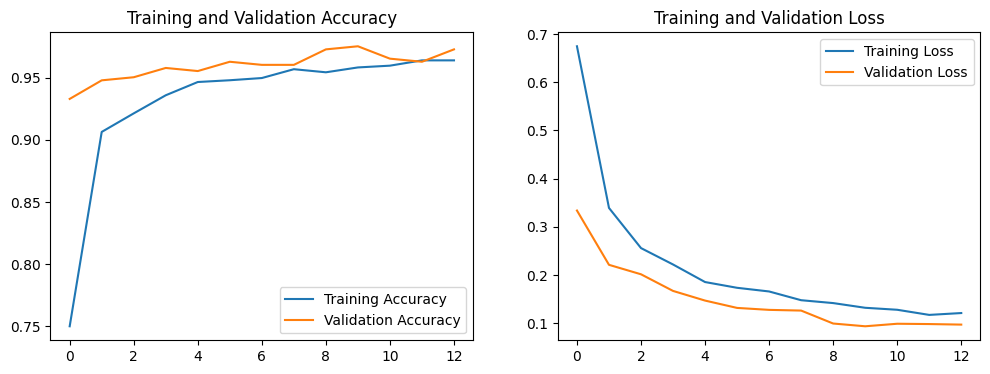

In [ ]:
# ดึงค่า Loss และ Accuracy จาก History
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

# สร้างกราฟ Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# สร้างกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

**แสดงผลความแม่นยำของการทดสอบโมเดล**

In [ ]:
print("--- เริ่มการวัดผลโมเดลด้วย Test Set ---")
# รับค่าทั้งหมด 3 ค่าตามที่กำหนดใน metrics
loss, accuracy, auc = model_aug.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

--- เริ่มการวัดผลโมเดลด้วย Test Set ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9779 - auc: 0.9994 - loss: 0.0851
Test Loss: 0.0939
Test Accuracy: 0.9739
Test AUC: 0.9991


**2. ทำการทดสอบโมเดลด้วยชุดข้อมูล train ทั้งหมดโดยไม่ทำการ Augmentation**

**เตรียมชุดข้อมูล train ที่ไม่ได้ทำการ augmentation**

In [4]:
# สร้าง Data Pipeline
# สำหรับ Train: ปรับขนาด (preprocess) -> เตรียมข้อมูลล่วงหน้า (prefetch)
train_ds_no_aug = (train_ds
            .cache()
            .shuffle(buffer_size=1000)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

**โหลดโมเดลอีกครั้งเพื่อไม่ให้โมเดลโดนฝึกซ้ำในข้อมูลเดิม**

In [ ]:
# โหลด EfficientNetB0 ที่เทรนด้วย 'imagenet'
# include_top=False หมายถึง ไม่เอา Classification Head ส่วนบนสุดมาด้วย
base_model_no_aug = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# ทำการ "แช่แข็ง" ไม่ให้เลเยอร์ของ base_model_no_aug ถูกเทรนใหม่
base_model_no_aug.trainable = False

# สร้างโมเดลใหม่โดยเริ่มจาก base_model_no_aug ที่เราโหลดมา
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x_2 = base_model_no_aug(inputs, training=False) # training=False เพื่อให้ BatchNormalization ทำงานใน inference mode
x_2 = tf.keras.layers.GlobalAveragePooling2D()(x_2) # ลดมิติของ feature map
x_2 = tf.keras.layers.Dropout(0.2)(x_2) # ป้องกัน Overfitting
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x_2)

model_no_aug = tf.keras.Model(inputs, outputs)

# กำหนด Optimizer, Loss Function, และ Metrics
model_no_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy', # เหมาะสำหรับโจทย์ 2 คลาส
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# แสดงสรุปโครงสร้างของโมเดลทั้งหมด
model_no_aug.summary()

callbacks_2 = [
    tf.keras.callbacks.ModelCheckpoint("best_no_aug.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-7, monitor="val_loss"),
]

print("\n--- เริ่มการเทรนโมเดล ---")
history_no_aug = model_no_aug.fit(
    train_ds_no_aug,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_2
)
print("--- การเทรนโมเดลเสร็จสิ้น ---\n")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- เริ่มการเทรนโมเดล ---
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.6659 - auc: 0.8654 - loss: 0.8343 - val_accuracy: 0.9378 - val_auc: 0.9938 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.9231 - auc: 0.9928 - loss: 0.2584 - val_accuracy: 0.9502 - val_auc: 0.9973 - val_loss: 0.1772 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.9505 - auc: 0.9960 - loss: 0.1899 - val_accuracy: 0.9552 - val_auc: 0.9983 - val_loss: 0.1378 - learning_rate: 0.0010
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.9621 - auc: 0.9976 - loss: 0.1432 - val_accuracy: 0.9602 - val_auc: 0.9987 - val_loss: 0.1192 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9705 - auc: 0.9983 - loss: 0.1299 - val_accuracy: 0.9751 - val_auc: 0.9991 - val_loss: 0.1015 - learning_rate: 0.0010
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accur

**แสดงผลการเทรนของโมเดลที่ฝึกโดยไม่ทำการ augmentation**

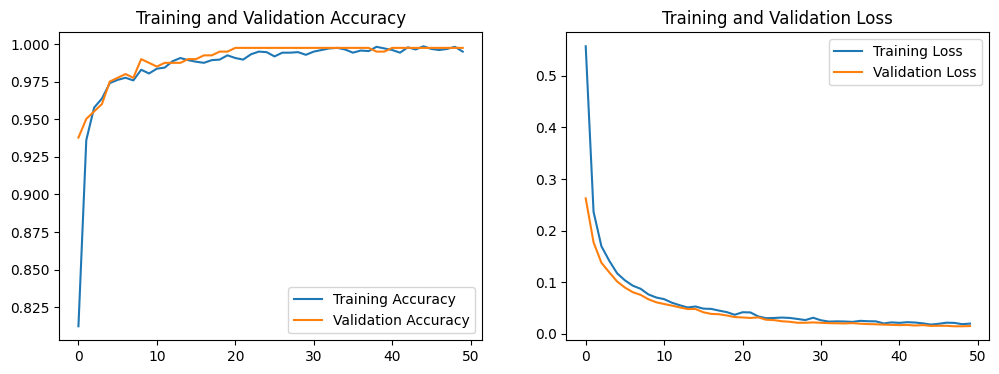

In [ ]:
# ดึงค่า Loss และ Accuracy จาก History
acc = history_no_aug.history['accuracy']
val_acc = history_no_aug.history['val_accuracy']
loss = history_no_aug.history['loss']
val_loss = history_no_aug.history['val_loss']

# สร้างกราฟ Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# สร้างกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

**แสดงผลการทดสอบของโมเดลที่ฝึกชุดข้อมูลที่ไม่ได้ทำ augmentation**

In [ ]:
print("--- เริ่มการวัดผลโมเดลด้วย Test Set ---")
# รับค่าทั้งหมด 3 ค่าตามที่กำหนดใน metrics
loss, accuracy, auc = model_no_aug.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

--- เริ่มการวัดผลโมเดลด้วย Test Set ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9939 - auc: 1.0000 - loss: 0.0161
Test Loss: 0.0144
Test Accuracy: 0.9963
Test AUC: 1.0000


**3.ฝึกโมเดลบนชุดข้อมูลที่น้อยลง + Augmentation**

**แบ่งข้อมูลใหม่เพื่อทดสอบในชุดข้อมูล train ที่น้อยลง**

In [5]:
train_size_1000 = 1000
val_size_500 = 500

# แบ่งข้อมูลโดยใช้ take และ skip
train_ds_1000 = all_ds_raw.take(train_size_1000)
remaining_ds = all_ds_raw.skip(train_size_1000)

val_ds_500 = remaining_ds.take(val_size_500)
test_ds_2526 = remaining_ds.skip(val_size_500) # ที่เหลือเป็น test

# ตรวจสอบจำนวนข้อมูลในแต่ละชุดหลังจากแบ่ง
print(f"\nจำนวนข้อมูลใน train_ds: {tf.data.experimental.cardinality(train_ds_1000).numpy()}")
print(f"จำนวนข้อมูลใน val_ds: {tf.data.experimental.cardinality(val_ds_500).numpy()}")
print(f"จำนวนข้อมูลใน test_ds: {tf.data.experimental.cardinality(test_ds_2526).numpy()}")

# สร้าง Data Pipeline
# สำหรับ Train: เพิ่มข้อมูล (augment) -> ปรับขนาด (preprocess) -> เตรียมข้อมูลล่วงหน้า (prefetch) -> Batch
train_ds_aug_1000 = (train_ds_1000
            .cache()
            .shuffle(buffer_size=1000)
            .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE) # เพิ่ม Batching หลัง Augmentation
            .prefetch(tf.data.AUTOTUNE))

# สำหรับ Validation และ Test: ปรับขนาด (preprocess) -> เตรียมข้อมูลล่วงหน้า (prefetch) -> Batch
val_ds_500  = (val_ds_500
           .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE) # เพิ่ม Batching
           .cache().prefetch(tf.data.AUTOTUNE))

test_ds_2526 = (test_ds_2526
           .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE) # เพิ่ม Batching
           .cache().prefetch(tf.data.AUTOTUNE))

# ตรวจสอบจำนวน Batch ในแต่ละชุดข้อมูลหลังจาก Batching
print(f"\nจำนวน Batch ใน train_ds_aug: {tf.data.experimental.cardinality(train_ds_aug_1000).numpy()}")
print(f"จำนวน Batch ใน val_ds: {tf.data.experimental.cardinality(val_ds_500).numpy()}")
print(f"จำนวน Batch ใน test_ds: {tf.data.experimental.cardinality(test_ds_2526).numpy()}")


จำนวนข้อมูลใน train_ds: 1000
จำนวนข้อมูลใน val_ds: 500
จำนวนข้อมูลใน test_ds: 2526

จำนวน Batch ใน train_ds_aug: 32
จำนวน Batch ใน val_ds: 16
จำนวน Batch ใน test_ds: 79


**สร้างโมเดลใหม่เพื่อทดสอบ**

In [ ]:
# โหลด EfficientNetB0 ที่เทรนด้วย 'imagenet'
# include_top=False หมายถึง ไม่เอา Classification Head ส่วนบนสุดมาด้วย
base_model_aug_1000 = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# ทำการ "แช่แข็ง" ไม่ให้เลเยอร์ของ base_model_no_aug ถูกเทรนใหม่
base_model_aug_1000.trainable = False

# สร้างโมเดลใหม่โดยเริ่มจาก base_model_no_aug ที่เราโหลดมา
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x_3 = base_model_aug_1000(inputs, training=False) # training=False เพื่อให้ BatchNormalization ทำงานใน inference mode
x_3 = tf.keras.layers.GlobalAveragePooling2D()(x_3) # ลดมิติของ feature map
x_3 = tf.keras.layers.Dropout(0.2)(x_3) # ป้องกัน Overfitting
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x_3)

model_aug_1000 = tf.keras.Model(inputs, outputs)

# กำหนด Optimizer, Loss Function, และ Metrics
model_aug_1000.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy', # เหมาะสำหรับโจทย์ 2 คลาส
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# แสดงสรุปโครงสร้างของโมเดลทั้งหมด
model_aug_1000.summary()

callbacks_3 = [
    tf.keras.callbacks.ModelCheckpoint("best_aug_1000.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-7, monitor="val_loss"),
]

print("\n--- เริ่มการเทรนโมเดล ---")
history_aug_1000 = model_aug_1000.fit(
    train_ds_aug_1000,
    epochs=EPOCHS,
    validation_data=val_ds_500,
    callbacks=callbacks_3
)
print("--- การเทรนโมเดลเสร็จสิ้น ---\n")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- เริ่มการเทรนโมเดล ---
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.4759 - auc: 0.7371 - loss: 1.1482 - val_accuracy: 0.8900 - val_auc: 0.9750 - val_loss: 0.5426 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.7989 - auc: 0.9522 - loss: 0.5861 - val_accuracy: 0.9100 - val_auc: 0.9869 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8543 - auc: 0.9793 - loss: 0.4208 - val_accuracy: 0.9280 - val_auc: 0.9916 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8854 - auc: 0.9861 - loss: 0.3491 - val_accuracy: 0.9300 - val_auc: 0.9928 - val_loss: 0.2829 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.9138 - auc: 0.9891 - loss: 0.3132 - val_accuracy: 0.9380 - val_auc: 0.9955 - val_loss: 0.2391 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accur

**แสดงผลการเทรนบนชุดข้อมูลที่น้อยลง**

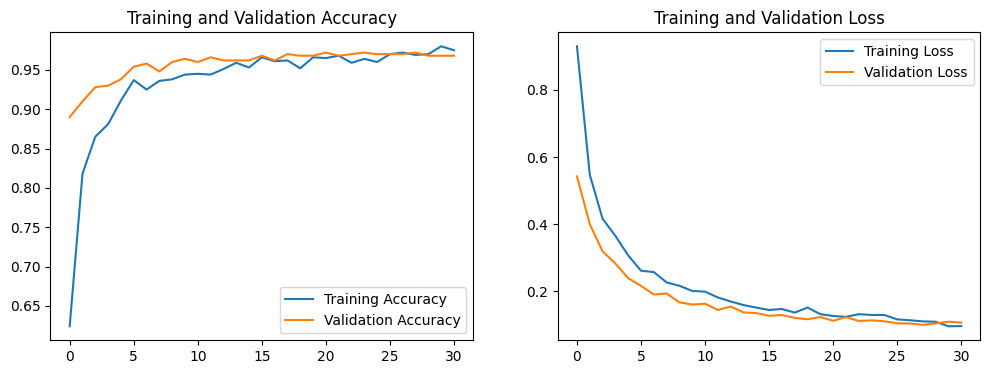

In [ ]:
# ดึงค่า Loss และ Accuracy จาก History
acc = history_aug_1000.history['accuracy']
val_acc = history_aug_1000.history['val_accuracy']
loss = history_aug_1000.history['loss']
val_loss = history_aug_1000.history['val_loss']

# สร้างกราฟ Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# สร้างกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

**ทดสอบโมเดลบนชุดข้อมูลที่ไม่เคยเห็น**

In [ ]:
print("--- เริ่มการวัดผลโมเดลด้วย Test Set ---")
# รับค่าทั้งหมด 3 ค่าตามที่กำหนดใน metrics
loss, accuracy, auc = model_aug_1000.evaluate(test_ds_2526)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

--- เริ่มการวัดผลโมเดลด้วย Test Set ---
79/79 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9707 - auc: 0.9987 - loss: 0.1000
Test Loss: 0.0959
Test Accuracy: 0.9735
Test AUC: 0.9988


**4.ฝึกโมเดลโมเดลบนชุดข้อมูลที่น้อยลงและไม่ทำ augmentation**

In [6]:
# สร้าง Data Pipeline
# สำหรับ Train: เพิ่มข้อมูล (augment) -> ปรับขนาด (preprocess) -> เตรียมข้อมูลล่วงหน้า (prefetch) -> Batch
train_ds_no_aug_1000 = (train_ds_1000
            .cache()
            .shuffle(buffer_size=1000)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE) # เพิ่ม Batching หลัง Augmentation
            .prefetch(tf.data.AUTOTUNE))

**สร้างโมเดลใหม่เพื่อทำการทดสอบ**

In [7]:
# โหลด EfficientNetB0 ที่เทรนด้วย 'imagenet'
# include_top=False หมายถึง ไม่เอา Classification Head ส่วนบนสุดมาด้วย
base_model_no_aug_1000 = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# ทำการ "แช่แข็ง" ไม่ให้เลเยอร์ของ base_model_no_aug ถูกเทรนใหม่
base_model_no_aug_1000.trainable = False

# สร้างโมเดลใหม่โดยเริ่มจาก base_model_no_aug ที่เราโหลดมา
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x_4 = base_model_no_aug_1000(inputs, training=False) # training=False เพื่อให้ BatchNormalization ทำงานใน inference mode
x_4 = tf.keras.layers.GlobalAveragePooling2D()(x_4) # ลดมิติของ feature map
x_4 = tf.keras.layers.Dropout(0.2)(x_4) # ป้องกัน Overfitting
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x_4)

model_no_aug_1000 = tf.keras.Model(inputs, outputs)

# กำหนด Optimizer, Loss Function, และ Metrics
model_no_aug_1000.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy', # เหมาะสำหรับโจทย์ 2 คลาส
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# แสดงสรุปโครงสร้างของโมเดลทั้งหมด
model_no_aug_1000.summary()

callbacks_4 = [
    tf.keras.callbacks.ModelCheckpoint("best_no_aug_1000.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-7, monitor="val_loss"),
]

print("\n--- เริ่มการเทรนโมเดล ---")
history_no_aug_1000 = model_no_aug_1000.fit(
    train_ds_no_aug_1000,
    epochs=EPOCHS,
    validation_data=val_ds_500,
    callbacks=callbacks_4
)
print("--- การเทรนโมเดลเสร็จสิ้น ---\n")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- เริ่มการเทรนโมเดล ---
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5462 - auc: 0.7838 - loss: 1.0700 - val_accuracy: 0.8380 - val_auc: 0.9651 - val_loss: 0.5306 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8585 - auc: 0.9715 - loss: 0.4732 - val_accuracy: 0.9020 - val_auc: 0.9848 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9143 - auc: 0.9895 - loss: 0.3190 - val_accuracy: 0.9240 - val_auc: 0.9910 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9225 - auc: 0.9918 - loss: 0.2787 - val_accuracy: 0.9360 - val_auc: 0.9930 - val_loss: 0.2473 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9522 - auc: 0.9961 - loss: 0.2060 - val_accuracy: 0.9520 - val_auc: 0.9954 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accura

**แสดงผลการเทรนของโมเดลบนชุดข้อมูลที่ไม่ได้ทำการ augmentation**

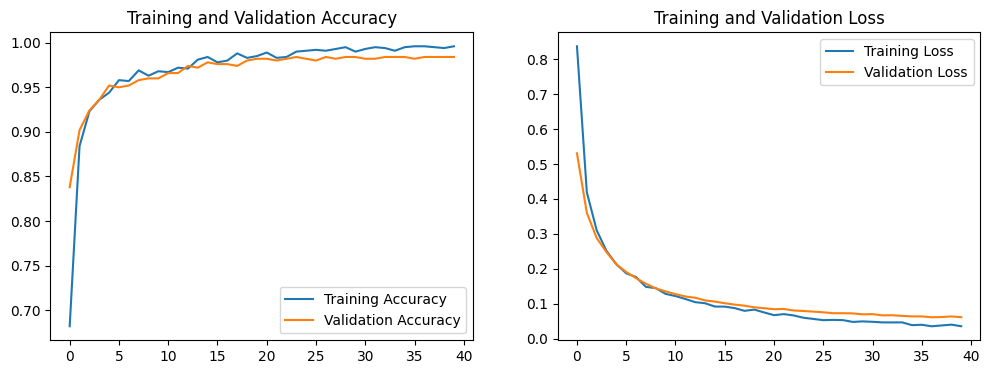

In [8]:
# ดึงค่า Loss และ Accuracy จาก History
acc = history_no_aug_1000.history['accuracy']
val_acc = history_no_aug_1000.history['val_accuracy']
loss = history_no_aug_1000.history['loss']
val_loss = history_no_aug_1000.history['val_loss']

# สร้างกราฟ Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# สร้างกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

**ทดสอบบนชุดข้อมูลที่ไม่เคยเห็น**

In [9]:
print("--- เริ่มการวัดผลโมเดลด้วย Test Set ---")
# รับค่าทั้งหมด 3 ค่าตามที่กำหนดใน metrics
loss, accuracy, auc = model_no_aug_1000.evaluate(test_ds_2526)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

--- เริ่มการวัดผลโมเดลด้วย Test Set ---
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9813 - auc: 0.9996 - loss: 0.0582
Test Loss: 0.0626
Test Accuracy: 0.9778
Test AUC: 0.9995
